In [1]:
import sys
sys.path.append("/global/u2/r/ritesh11/GSOC_2025/")

In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import re

from Flash.tokenizer import Tokenizer
from Flash.constants import SPECIAL_SYMBOLS, PAD_IDX, UNK_IDX, T_IDX, BOS_IDX, EOS_IDX, SEP_IDX

In [49]:
df = pd.read_csv("/pscratch/sd/r/ritesh11/QCD/data/QCD_2-2-3-4test.csv")
res_dir = "/pscratch/sd/r/ritesh11/QCD/data/QCD_2-2-3-4termwisetest.csv"

In [50]:
tokenizer = Tokenizer(df,100,SPECIAL_SYMBOLS,UNK_IDX,False)

In [51]:
def split_expression(expr: str):
    terms = []
    current = []
    depth = 0
    i = 0
    while i < len(expr):
        char = expr[i]

        if char == '(':
            depth += 1
            current.append(char)
        elif char == ')':
            depth -= 1
            current.append(char)
        elif char in '+-' and depth == 0:
            if current:
                terms.append(''.join(current).strip())
                current = [char] if char == '-' else []
            else:
                current.append(char) 
        else:
            current.append(char)
        i += 1

    if current:
        terms.append(''.join(current).strip())

    return [term for term in terms if term]

In [52]:
def split_term_by_top_level_mul(term):
    """
    Split at * only if it appears at top-level and between two parenthesis blocks: )*(.
    Also extract common divisors of the form (...) / (...) if '/' is at top-level.
    """
    parts = []
    depth = 0
    curr = ''
    n = len(term)
    common_divisor = None
    i = 0

    while i < n:
        c = term[i]
        
        # Update depth
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1

        # Check for top-level )*( pattern
        if (
            c == '*' and depth == 0
            and i > 0 and i < n - 1
            and term[i - 1] == ')' and term[i + 1] == '('
        ):
            if curr.strip():
                parts.append(curr.strip())
            curr = ''
            i += 1
            continue

        # Check for top-level )/( pattern (common divisor)
        if (
            c == '/' and depth == 0
            and i > 0 and i < n - 1
            and term[i - 1] == ')' and term[i + 1] == '('
        ):
            if curr.strip():
                parts.append(curr.strip())
            # Everything after '/' is the common divisor
            common_divisor = term[i + 1:].strip()
            break  # Do not add '/' to curr, exit here

        curr += c
        i += 1

    if curr.strip() and not common_divisor:
        parts.append(curr.strip())

    return parts, common_divisor

In [53]:
def tokenize_split_expression(expr: str) -> list:
    """
    Splits a symbolic algebraic expression into top-level terms,
    respecting parentheses and nested expressions.
    """
    terms = []
    current = []
    depth = 0
    i = 0
    expr = tokenizer.tgt_tokenize(expr)
    while i < len(expr):
        char = expr[i]

        if char == '(':
            depth += 1
            current.append(char)
        elif char == ')':
            depth -= 1
            current.append(char)
        elif char == 'i' or char =='g':
            depth=0
            current.append(char)
            
        elif char in '+-' and depth == 0:
            # If '+' or '-' is at top level, treat as separator
            if current:
                terms.append(''.join(current).strip())
                current = [char] if char == '-' else []
            else:
                current.append(char)  # for unary minus at start
        else:
            current.append(char)
        i += 1

    if current:
        terms.append(''.join(current).strip())

    return [term for term in terms if term]

In [54]:
def check_parentheses_balance(expr):
    depth = 0
    for i, c in enumerate(expr):
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1
            if depth < 0:
                return f"Unmatched closing parenthesis at position {i}"
    if depth > 0:
        return f"{depth} unmatched opening parenthesis(es)"
    elif depth < 0:
        return f"{-depth} unmatched closing parenthesis(es)"
    else:
        return True

In [55]:
lens = []
exps = []
for sqamp in tqdm(df.sqamp.tolist()):
    temp = [e for e in split_expression(sqamp)]
    exps.append(temp)
    lens.append(len(temp))

100%|██████████| 1439/1439 [00:02<00:00, 547.67it/s]


In [56]:
split_exps = [] 
for exp in tqdm(exps):
    temp_exp_list = []
    for e in exp:
        temp = split_term_by_top_level_mul(e)
        temp_exp_list.append(temp)
    split_exps.append(temp_exp_list)

100%|██████████| 1439/1439 [00:02<00:00, 514.24it/s]


In [57]:
simpl_exps = []

In [58]:
for exp in tqdm(split_exps):
    temp = []
    for e in exp:
        term = e[0][0]
        temp.append(tokenize_split_expression(term))
    simpl_exps.append(temp)

100%|██████████| 1439/1439 [00:04<00:00, 304.19it/s]


In [59]:
for exp_idx, exp in enumerate(simpl_exps):
    for e_idx, e in enumerate(exp):
        if len(e) > 1:
            s = e[0]
            i_pos = min(
                (s.find('i') if 'i' in s else float('inf')),
                (s.find('g') if 'g' in s else float('inf'))
            )
            if i_pos == float('inf'):
                raise ValueError(
                    f"No 'i' or 'g' found in e[0] at simpl_exps[{exp_idx}][{e_idx}] → e[0] = {s}"
                )
            
            # Look for first '(' after first 'i' or 'g'
            open_paren_pos = s.find('(', i_pos)
            if open_paren_pos == -1:
                raise ValueError(
                    f"No '(' found after 'i'/'g' in e[0] at simpl_exps[{exp_idx}][{e_idx}] → e[0] = {s}"
                )

            prefix = s[:open_paren_pos]
            assert "i" in prefix or "g" in prefix, \
                f"Assertion failed at simpl_exps[{exp_idx}][{e_idx}] → prefix = '{prefix}', e = {e}"

            e[0] = e[0] + ")"
            e[-1] = prefix + "(" + e[-1]
            for i in range(1, len(e) - 1):
                e[i] = prefix + "(" + e[i] + ")"


In [60]:
for i in range(len(simpl_exps)):
    for j in range(len(simpl_exps[i])):
        mul = ""
        div = split_exps[i][j][1]
        if len(split_exps[i][j][0]) > 1:
            for m in split_exps[i][j][0][1:]:
                mul= mul + "*" + m
        for k,exp in enumerate(simpl_exps[i][j]):
            if mul:
                exp = exp + "*" + mul
            if div:
                exp = exp + "/" + div
            simpl_exps[i][j][k] = exp

In [61]:
for i, exp in enumerate(simpl_exps):
    simpl_exps[i] = [item for sublist in exp for item in sublist]

In [62]:
for e in tqdm(simpl_exps):
    for exp in e:
        assert check_parentheses_balance(exp)

100%|██████████| 1439/1439 [00:01<00:00, 1389.49it/s]


In [63]:
SPECIAL_SYMBOLS[-1]

'<T69>'

In [64]:
for exp in tqdm(simpl_exps):
    for i in range(len(exp)):
        if i==0:
            if(len(exp) == 1):
                exp[i] = SPECIAL_SYMBOLS[BOS_IDX] + exp[i] + SPECIAL_SYMBOLS[EOS_IDX]
            else:
                exp[i] = SPECIAL_SYMBOLS[BOS_IDX] + exp[i] + SPECIAL_SYMBOLS[SEP_IDX]
        elif i==len(exp)-1:
            exp[i] = SPECIAL_SYMBOLS[T_IDX[i]] + exp[i] + SPECIAL_SYMBOLS[EOS_IDX]
        else:
            exp[i] = SPECIAL_SYMBOLS[T_IDX[i]] + exp[i] + SPECIAL_SYMBOLS[SEP_IDX]

100%|██████████| 1439/1439 [00:00<00:00, 83632.68it/s]


In [65]:
simpl_exps[12]

['<BOS>16/27*g^4*MOMENTUM_14*MOMENTUM_24*(MOMENTUM_13+-1/2*reg_prop)^(-2)<SEP>',
 '<T1>32/27*i*g^2*(i*g^2*m_t^2*(m_t^2+1/2*MOMENTUM_12)/(MOMENTUM_13+-1/2*reg_prop))/(MOMENTUM_13+-1/2*reg_prop)<SEP>',
 '<T2>32/27*i*g^2*(-1/2*i*g^2*m_t^2*(MOMENTUM_14+2*MOMENTUM_24)/(MOMENTUM_13+-1/2*reg_prop))/(MOMENTUM_13+-1/2*reg_prop)<EOS>']

In [66]:
amps = df.amp.tolist()

In [67]:
data = {"amp":[], "sqamp":[]}

In [68]:
for a,sqa in zip(amps,simpl_exps):
    for e in sqa:
        data['amp'].append(a)
        data['sqamp'].append(e)

In [69]:
df_new = pd.DataFrame(data)

In [70]:
df_new

,amp,sqamp
0,i*g^2*(MOMENTUM_1_ % \ INDEX_0*gamma_{ % \ I...,<BOS>16/27*g^4*MOMENTUM_14*MOMENTUM_24*(MOMENT...
1,i*g^2*(MOMENTUM_1_ % \ INDEX_0*gamma_{ % \ I...,<T1>32/27*i*g^2*(i*g^2*m_t^2*(m_t^2+1/2*MOMENT...
2,i*g^2*(MOMENTUM_1_ % \ INDEX_0*gamma_{ % \ I...,<T2>32/27*i*g^2*(-1/16*i*g^2*m_t^2*(16*MOMENTU...
3,i*g^2*(MOMENTUM_1_ % \ INDEX_0*gamma_{ % \ I...,<BOS>16/27*g^4*MOMENTUM_14*MOMENTUM_24*(MOMENT...
4,i*g^2*(MOMENTUM_1_ % \ INDEX_0*gamma_{ % \ I...,<T1>32/27*i*g^2*(i*g^2*m_t^2*(m_t^2+1/2*MOMENT...
...,...,...
25214,-1/32*i*g^4*(MOMENTUM_3_ % \ INDEX_0*gamma_{+...,<T11>1/24576*i*g^4*(128/9*i*g^4*(m_d^2*(128*m_...
25215,-1/32*i*g^4*(MOMENTUM_3_ % \ INDEX_0*gamma_{+...,<T12>-1/216*i*g^4*(i*g^4*(m_d^6*m_t^2+1/2*m_d^...
25216,-1/32*i*g^4*(MOMENTUM_3_ % \ INDEX_0*gamma_{+...,<T13>-1/216*i*g^4*(1/96*i*g^4*((-48)*m_d^6*m_t...
25217,-1/32*i*g^4*(MOMENTUM_3_ % \ INDEX_0*gamma_{+...,<T14>-1/12*i*g^4*(i*g^4*(m_d^6*m_t^2+1/2*m_d^6...


In [71]:
df_new.to_csv(res_dir,index=False)

In [66]:
lens = []

In [25]:
for e in tqdm(simpl_exps):
    lens.append(len(e))

100%|██████████| 9318/9318 [00:00<00:00, 3222769.41it/s]


In [26]:
lens = np.array(lens)

In [27]:
np.argmax(lens)

np.int64(9839)

In [28]:
len(simpl_exps)

9318

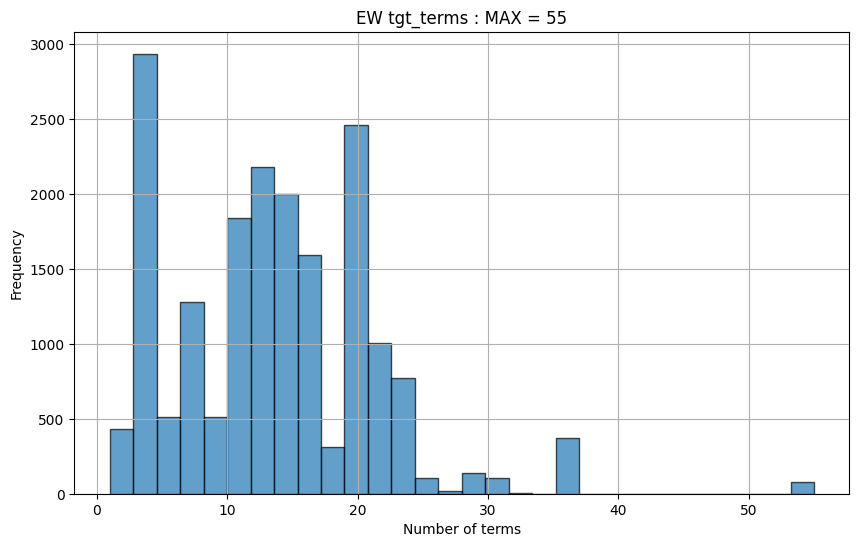

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(lens, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'EW tgt_terms : MAX = {lens.max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [30]:
term_lens= []
for exp in tqdm(exps):
    for e in exp:
        term_lens.append(len(tokenizer.tgt_tokenize(e)))

100%|██████████| 9318/9318 [00:26<00:00, 347.46it/s] 


In [31]:
term_lens = np.array(term_lens)

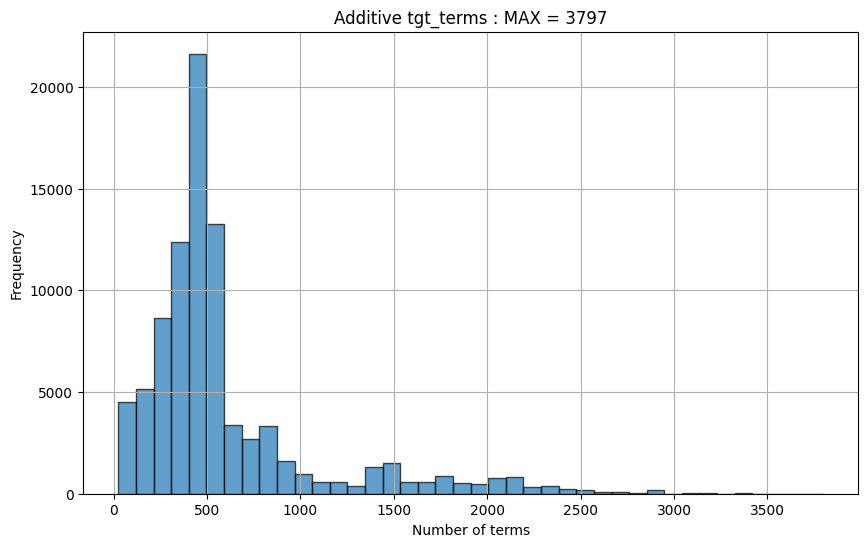

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(term_lens, bins=40, edgecolor='black', alpha=0.7)
plt.title(f'Additive tgt_terms : MAX = {term_lens.max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [34]:
term_lens= []
for exp in tqdm(simpl_exps):
    for e in exp:
        term_lens.append(len(tokenizer.tgt_tokenize(e)))

100%|██████████| 9318/9318 [00:29<00:00, 310.83it/s]


In [35]:
term_lens = np.array(term_lens)

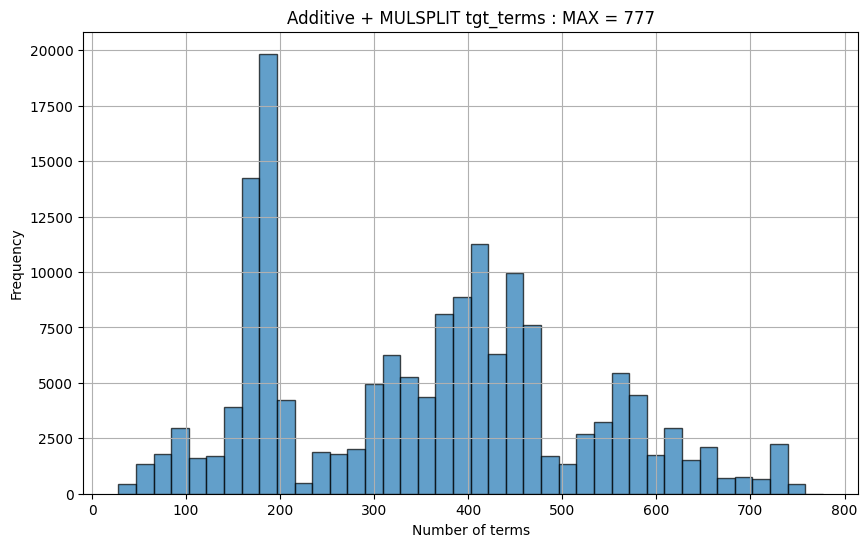

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(term_lens, bins=40, edgecolor='black', alpha=0.7)
plt.title(f'Additive + MULSPLIT tgt_terms : MAX = {term_lens.max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [37]:
seq_lens = []

In [38]:
for exp in tqdm(df.sqamp.tolist()):
    seq_lens.append(len(tokenizer.tgt_tokenize(exp)))

100%|██████████| 9318/9318 [00:25<00:00, 369.27it/s] 


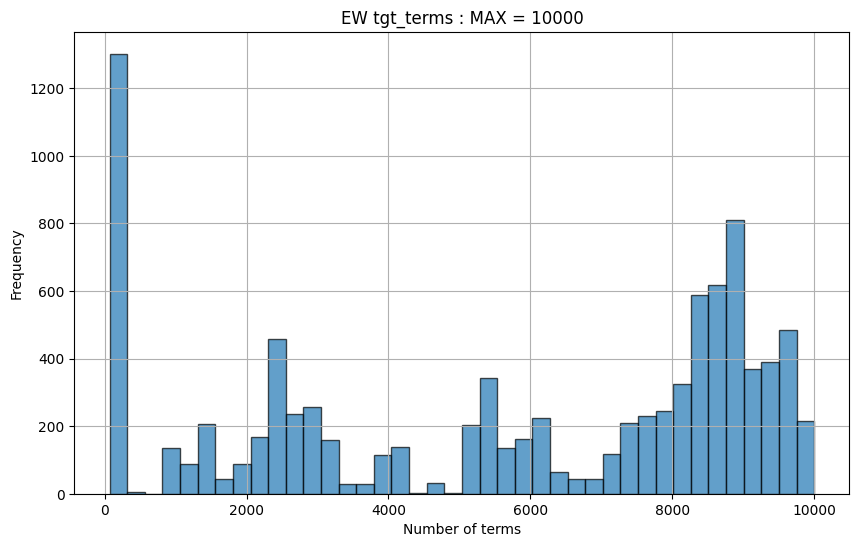

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(np.array(seq_lens), bins=40, edgecolor='black', alpha=0.7)
plt.title(f'EW tgt_terms : MAX = {np.array(seq_lens).max()}')
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()